# **Deep Research with Bing Search**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow includes:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Content Analysis** - Summarizing search results and extracting key insights 
4. **Report Generation** - Creating detailed research reports with proper citations
5. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- SummaryAgent - Extracts key insights from retrieved content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Agent Service

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

## Required Environment Variables

This notebook requires the following environment variables in your `.env` file:

```bash
# Azure AI Projects Configuration
PROJECT_ENDPOINT=your_azure_ai_project_endpoint

# Pre-created Agent IDs (must be created via common/create_azure_ai_agents.py)
PlannerAgentID=your_planner_agent_id
BingSearchAgentID=your_bing_search_agent_id
SummaryAgentID=your_summary_agent_id
ResearchAgentID=your_research_agent_id
PeerReviewAgentID=your_peer_review_agent_id
```

**Note:** This notebook uses **pure Azure AI Agents** - all agents must be pre-created in Azure AI Foundry. Unlike notebooks 01 and 02, no agents are created inline. Run the agent creation cells below (commented out) once to create your agents, then use their IDs in subsequent runs.

In [1]:
import dotenv
dotenv.load_dotenv(".env", override=True)

True

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [2]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
import os

project_client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint=os.getenv("PROJECT_ENDPOINT")
)

### Creating Azure AI Agents (One-time Setup)

The following cell will **create all Azure AI Agents** required for this workflow. You only need to run this cell **once** to create the agents, then save their IDs to your `.env` file.

After creating the agents, uncomment the fetch agents cell below and comment out this creation cell for subsequent runs.

In [3]:
# from common.create_azure_ai_agents import (
#     create_bing_search_agent,
#     create_research_plan_agent,
#     create_summary_agent,
#     create_research_report_agent,
#     create_peer_review_agent
# )

# planner_agent = create_research_plan_agent(project_client=project_client)
# bing_search_agent = create_bing_search_agent(project_client=project_client)
# summary_agent = create_summary_agent(project_client=project_client)
# research_agent = create_research_report_agent(project_client=project_client)
# peer_review_agent = create_peer_review_agent(project_client=project_client)

### Fetch Agents from Azure AI Foundry

Once you've created your agents (using the cell above), use this cell to retrieve them by their IDs from your `.env` file. This is the standard approach for working with pre-created Azure AI Agents.

In [4]:
planner_agent = project_client.agents.get_agent(agent_id=os.getenv("PlannerAgentID"))
bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("BingSearchAgentID"))
summary_agent = project_client.agents.get_agent(agent_id=os.getenv("SummaryAgentID"))
research_agent = project_client.agents.get_agent(agent_id=os.getenv("ResearchAgentID"))
peer_review_agent = project_client.agents.get_agent(agent_id=os.getenv("PeerReviewAgentID"))

### Update Agent Instructions

This cell updates the system instructions for all agents with current date awareness and any refined prompts. Run this cell each time you want to ensure agents have the latest instructions, especially for date-sensitive queries.

In [5]:
from common.update_instructions import (
    update_planner_instructions,
    update_bing_instructions,
    update_summary_instructions,
    update_research_instructions,
    update_peer_review_instructions
)

planner_agent = update_planner_instructions(agent=planner_agent)
bing_search_agent = update_bing_instructions(agent=bing_search_agent)
summary_agent = update_summary_instructions(agent=summary_agent)
research_agent = update_research_instructions(agent=research_agent)
peer_review_agent = update_peer_review_instructions(agent=peer_review_agent)

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Analysis** → SummaryAgent processes results, extracting key insights while preserving technical details
5. **Synthesis** → ResearchAgent creates well-structured report with proper citations
6. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
7. **Revision** → If needed, research report undergoes improvement cycles based on feedback
8. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

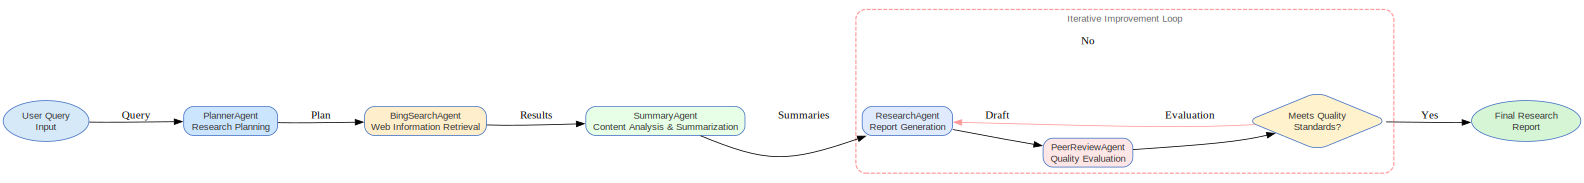

In [6]:
from common.helper import create_research_workflow_diagram

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram()
workflow_diagram

Let's start with a sample research query.

In [7]:
# user_query="What big industries will AI have the most affected on?"
user_query="What are the differences between classical machine learning, deep learning and generative AI?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [8]:
from azure.ai.agents.models import MessageRole
from common.data_models import ResearchPlan
from common.utils_ai_agents import (
    add_user_message_to_thread,
    invoke_agent
)
import json

# create a thread and add the user message
thread = project_client.agents.threads.create()
add_user_message_to_thread(project_client, thread.id, user_query)

# invoke the planner agent to create a research plan
planner_agent_output, thread = invoke_agent(
    project_client=project_client,
    thread=thread,
    agent=planner_agent
)

# parse the output to a ResearchPlan object
plan_data = json.loads(planner_agent_output)
plan = ResearchPlan(**plan_data)

# delete the thread
project_client.agents.threads.delete(thread_id=thread.id)

In [9]:
plan.research_tasks[0].search_queries

['Classical machine learning vs deep learning vs generative AI methodologies',
 'Comparison of foundational algorithms in classical ML, deep learning, and generative AI']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. We send multiple search queries to gather diverse perspectives
2. The agent returns structured search results with titles, full_text, and URLs
3. Results are organized by subtopic for further processing

This step leverages Azure AI Projects with Bing Search integration to ensure up-to-date information from across the web.

In [10]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import defaultdict
from typing import Dict, Any, List, Tuple
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

MAX_WORKERS = 8  # adjust for your rate limits

def run_one_query(subtopic_name: str, query: str) -> Dict[str, Any]:
    prompt = f"""
    Research the following query: {query}
    This is related to subtopic: {subtopic_name}
    Please provide the information and cite your sources using the available tools.
    """
    thread = None
    try:
        thread = project_client.agents.threads.create()
        add_user_message_to_thread(project_client, thread.id, prompt)

        _out, _ = invoke_agent(
            project_client=project_client,
            thread=thread,
            agent=bing_search_agent
        )

        text, urls = extract_agent_response_and_urls(project_client, thread.id, query)
        return {"query": query, "agent_response": text, "results": urls}
    except Exception as e:
        return {"query": query, "results": [], "error": str(e)}
    finally:
        try:
            if thread is not None:
                project_client.agents.threads.delete(thread_id=thread.id)
        except Exception:
            pass

# Flatten tasks
# si: index of the subtopic
# qi: index of the query within that subtopic
# st.subtopic: the subtopic name
# q: the query text

tasks: List[Tuple[int, int, str, str]] = [
    (si, qi, st.subtopic, q)
    for si, st in enumerate(plan.research_tasks)
    for qi, q in enumerate(st.search_queries)
]

# Run in parallel
results = defaultdict(dict)  # results[si][qi] = entry
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
    fmap = {ex.submit(run_one_query, subtopic_name, query): (si, qi)
            for si, qi, subtopic_name, query in tasks}
    for fut in tqdm(as_completed(fmap), total=len(fmap), desc="Running research queries in parallel"):
        si, qi = fmap[fut]
        try:
            results[si][qi] = fut.result()
        except Exception as e:
            results[si][qi] = {"query": tasks[si][3], "results": [], "error": str(e)}

# Rebuild in original shape and order
search_results: List[Dict[str, Any]] = []
for si, st in enumerate(plan.research_tasks):
    queries = [results[si].get(qi, {"query": q, "results": [], "error": "Missing result"})
               for qi, q in enumerate(st.search_queries)]
    search_results.append({"subtopic": st.subtopic, "queries": queries})

# Quick status
for block in search_results:
    ok = sum(1 for q in block["queries"] if "error" not in q)
    print(f"{block['subtopic']}: {ok}/{len(block['queries'])} queries succeeded")


Running research queries in parallel: 100%|██████████| 6/6 [00:28<00:00,  4.69s/it]

Core principles and methodologies: 2/2 queries succeeded
Typical applications and use cases: 2/2 queries succeeded
Technological requirements and limitations: 2/2 queries succeeded


In [11]:
print(f"Planned total search queries: {sum(1 for task in plan.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 6

Actually total search queries: 6



### Step 3: Content Analysis and Summarization

For each search result retrieved, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the raw search content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms raw search data into structured, information-rich summaries that will form the basis of our research report.

In [12]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Dict, Any, List, Tuple
from tqdm import tqdm
from common.utils_summary import collect_responses_and_citations

MAX_WORKERS_SUMMARY = 5

def summarize_one(subtopic_result: Dict[str, Any]) -> Dict[str, Any]:
    all_responses, unique_citations = collect_responses_and_citations(subtopic_result)
    content = "\n\n---\n\n".join(all_responses)

    summary = "No content found to summarize for this subtopic."
    thread = None
    if content:
        summary_prompt = (
            f"Summarize the following information related to the subtopic "
            f"'{subtopic_result.get('subtopic', 'Unknown Subtopic')}':\n\n{content}"
        )
        try:
            thread = project_client.agents.threads.create()
            add_user_message_to_thread(project_client, thread.id, summary_prompt)
            out, _ = invoke_agent(project_client=project_client, thread=thread, agent=summary_agent)
            summary = out.strip()
        except Exception as e:
            sub = subtopic_result.get('subtopic', 'Unknown Subtopic')
            summary = f"Error during summarization for subtopic '{sub}'. Details: {e}"
        finally:
            try:
                if thread is not None:
                    project_client.agents.threads.delete(thread_id=thread.id)
            except Exception:
                pass

    citations_list = [{"title": t, "url": u} for (t, u) in unique_citations]
    return {
        "subtopic": subtopic_result.get("subtopic", "Unknown Subtopic"),
        "summary": summary,
        "citations": citations_list,
    }

# Run all subtopics in parallel and preserve order
mapped_chunks: List[Dict[str, Any]] = [None] * len(search_results)

with ThreadPoolExecutor(max_workers=MAX_WORKERS_SUMMARY) as ex:
    fmap = {ex.submit(summarize_one, subtopic_result): i
            for i, subtopic_result in enumerate(search_results)}
    for fut in tqdm(as_completed(fmap), total=len(fmap), desc="Summarizing subtopics in parallel"):
        i = fmap[fut]
        try:
            mapped_chunks[i] = fut.result()
        except Exception as e:
            sub = search_results[i].get("subtopic", "Unknown Subtopic")
            mapped_chunks[i] = {
                "subtopic": sub,
                "summary": f"Error during summarization for subtopic '{sub}'. Details: {e}",
                "citations": [],
            }

# Optional: quick status
ok = sum(1 for m in mapped_chunks if m and not m["summary"].startswith("Error during summarization"))
print(f"Summaries completed: {ok}/{len(mapped_chunks)}")


Summarizing subtopics in parallel: 100%|██████████| 3/3 [00:29<00:00,  9.95s/it]

Summaries completed: 3/3


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [13]:
def print_thread_messages(thread):
    messages = project_client.agents.messages.list(thread_id=thread.id)
    for m in messages:
        print(f"roll: {m.role}")
        print(f"agent_id: {m.agent_id}")
        print(f"content: {m.content[0]['text']['value']}")
        print("---")

In [14]:
from common.data_models import ComprehensiveResearchReport, PeerReviewFeedback
from common.utils_ai_agents import add_user_message_to_thread

def loop_agents(project_client, agent_a, agent_b, initial_input, max_iterations=10):
    """
    Loop between two agents until agent B produces the target output.
    
    Args:
        agent_a: Function that takes input and returns output
        agent_b: Function that takes input and returns output
        initial_input: Starting input for agent A
        max_iterations: Safety limit to prevent infinite loops
    
    Returns:
        The final output from agent B, or None if max iterations reached
    """
    current_input = initial_input
    thread = project_client.agents.threads.create()
    add_user_message_to_thread(project_client, thread.id, current_input)

    for i in range(max_iterations):
        # Agent A processes the input and produces output
        a_output, thread = invoke_agent(
            project_client=project_client,
            thread=thread,
            agent=agent_a
        )

        handover_message = f"A research agent has produced a research report. Please review it."
        add_user_message_to_thread(project_client, thread.id, handover_message)
        
        # Agent B reviews the output
        b_output, thread = invoke_agent(
            project_client=project_client,
            thread=thread,
            agent=agent_b
        )

        b_output_json = json.loads(b_output)
        review = PeerReviewFeedback(**b_output_json)

        # Check if B produced the target output
        if review.is_satisfactory is not False:
            print(f"Target output reached after {i+1} iterations!")
            report_json = json.loads(a_output)
            final_report = ComprehensiveResearchReport(**report_json)

            # delete the thread
            # print_thread_messages(thread)
            project_client.agents.threads.delete(thread_id=thread.id)
            return final_report
        
        # Use B's output as input for the next iteration
        current_input = b_output
        
        handover_message = f"Peer review agent has provided feedback. Please revise the research report based on the feedback."
        add_user_message_to_thread(project_client, thread.id, handover_message)

    # delete the thread
    # print_thread_messages(thread)
    project_client.agents.threads.delete(thread_id=thread.id)
    print(f"Max iterations ({max_iterations}) reached without finding target output")

    return None

In [15]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

research_query = (
    "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
    "using the following content. **Minimize bullet points** and ensure the final text resembles "
    "a cohesive, academic-style paper:\n\n"
    f"{research_input_prompt}\n\n"
    "As a final reminder, don't forget to include the citation list at the end of the report."
)

# Run the loop
final_report = loop_agents(
    project_client=project_client,
    agent_a=research_agent,
    agent_b=peer_review_agent,
    initial_input=research_query,
    max_iterations=10
)

Target output reached after 1 iterations!


In [16]:
from IPython.display import display, Markdown
display(Markdown(final_report.research_report))

# Comparative Analysis of Classical Machine Learning, Deep Learning, and Generative AI: Methodologies, Applications, and Technological Foundations

## Introduction

Artificial intelligence (AI) has undergone a dramatic evolution over the past several decades, giving rise to a diverse spectrum of methodologies that span classical machine learning, deep learning, and the most recent frontier—generative AI. Each of these paradigms is distinguished by unique philosophical foundations, algorithmic approaches, and technological requirements, which in turn shape their respective applications and impact across industries. This report provides an exceptionally comprehensive, paragraph-focused analysis of these three pillars of modern AI, synthesizing their core principles, typical use cases, and technological underpinnings. The goal is to offer a nuanced, authoritative comparison that informs both practitioners and decision-makers about the strengths, limitations, and future trajectories of these transformative technologies.

## Core Principles and Methodologies

### Classical Machine Learning: Foundations and Approaches

Classical machine learning (ML) is fundamentally rooted in statistical theory and algorithmic pattern recognition, relying on the explicit representation of data through manual feature engineering. The practitioner’s expertise is central to this paradigm, as the selection and crafting of features—those measurable properties or characteristics of the data—directly influence model performance and interpretability. Classical ML encompasses three primary learning modalities: supervised learning, unsupervised learning, and reinforcement learning. Supervised learning involves training models on labeled datasets to perform tasks such as classification (e.g., spam detection) or regression (e.g., price prediction). Unsupervised learning, by contrast, seeks to uncover hidden structures in unlabeled data, as seen in clustering algorithms for customer segmentation. Reinforcement learning, though less common in traditional ML, enables models to optimize behaviors through iterative feedback from their environment, often applied in control systems and robotics.

The canonical algorithms of classical ML include linear regression, logistic regression, support vector machines (SVM), decision trees, and Naive Bayes classifiers. These algorithms are typically implemented in a stepwise workflow: data collection, preprocessing, feature selection, algorithm choice, iterative model training, evaluation, and deployment. The interpretability of classical ML models is a defining strength, allowing practitioners to trace predictions back to specific features and understand the rationale behind decisions. This transparency is especially valued in regulated sectors such as finance and healthcare, where accountability is paramount. However, classical ML’s reliance on structured, tabular data and manual feature engineering imposes limitations on scalability and adaptability, particularly when confronted with high-dimensional or unstructured datasets such as images or natural language text [1][2][3][4][5][6][7][8].

### Deep Learning: Automated Feature Extraction and Hierarchical Representation

Deep learning (DL) represents a methodological leap from classical ML by automating the process of feature extraction through multi-layered artificial neural networks. Inspired by the structure of biological neural networks, deep learning models consist of interconnected neurons organized into input, hidden, and output layers. The depth of these networks—often comprising dozens or even hundreds of layers—enables the learning of hierarchical representations, from low-level edges in images to high-level semantic concepts in text. Foundational architectures include multilayer perceptrons (MLP), convolutional neural networks (CNNs), recurrent neural networks (RNNs), and transformers. CNNs excel at spatial data processing, making them the backbone of image and video recognition systems. RNNs and their variants (such as LSTM and GRU) are tailored for sequential data, powering applications in natural language processing (NLP) and time series analysis. Transformers, leveraging self-attention mechanisms, have revolutionized NLP by enabling models to capture long-range dependencies and context within text sequences.

The training of deep learning models is computationally intensive, requiring extensive labeled datasets and high-performance hardware—often GPU acceleration—to perform backpropagation and optimize network weights. Unlike classical ML, deep learning minimizes manual intervention in feature creation, instead learning complex, non-linear mappings directly from raw data. This capability makes DL highly scalable and versatile, excelling in domains characterized by unstructured inputs such as images, speech, and text. However, the complexity and opacity of deep learning models—often described as “black boxes”—pose significant challenges for interpretability and transparency, particularly in critical decision-making contexts. Additionally, the resource demands of deep learning, both in terms of data and computation, can be prohibitive for organizations lacking specialized infrastructure [1][2][3][4][5][7][8].

### Generative AI: Creation and Simulation through Advanced Architectures

Generative AI marks the latest and most advanced evolution in the AI landscape, building upon deep learning to shift the focus from prediction and classification to the creation of novel data. The core principle of generative AI is the modeling of the underlying probability distribution of observed data, enabling the generation of new, plausible samples that mimic the characteristics of the training set. This paradigm is realized through several sophisticated architectures, including Generative Adversarial Networks (GANs), Variational Autoencoders (VAEs), diffusion models, autoregressive models, and transformers.

GANs, introduced by Goodfellow et al., consist of two neural networks—the generator and the discriminator—engaged in a competitive, game-theoretic loop that iteratively refines the quality of generated outputs. VAEs encode input data into a latent representation and decode it to reconstruct and generate new samples, optimizing for probabilistic consistency. Diffusion models, which have recently achieved state-of-the-art results in high-fidelity image synthesis, iteratively add and remove noise to generate realistic imagery. Autoregressive models, exemplified by the GPT family, sequentially generate content by predicting each subsequent token based on preceding context. Transformers underpin large language models (LLMs), handling vast sequences for tasks such as text generation, question answering, and code synthesis.

Generative AI models are trained on massive, diverse datasets and demand enormous computational power, often necessitating distributed cloud infrastructure and specialized hardware. Their automatic feature learning supports advanced applications in content creation (art, text, video, music), conversational agents, code generation, and scientific discovery (e.g., drug design and molecular simulation). The complexity and resource intensity of generative AI surpass those of classical ML and deep learning, while interpretability remains a significant challenge. The exponential growth in synthetic media, automation, and discovery driven by generative AI raises important questions about model fairness, ethical deployment, and resource sustainability [1][2][3][4][5][7][8].

### Comparative Summary of Methodologies

The progression from classical ML to deep learning and generative AI is marked by increasing complexity, data requirements, and application breadth. Classical ML relies on manual feature engineering, moderate data, and structured inputs, offering interpretability and moderate scalability. Deep learning automates feature extraction, requires large-scale labeled data, and excels with unstructured inputs, but sacrifices transparency for scalability and versatility. Generative AI, at the frontier, leverages automatic feature learning and massive datasets to create new content, demanding the highest computational resources and presenting the lowest interpretability. This stratification is critical for organizations seeking to balance transparency, scalability, data availability, and innovation in their AI strategies [1][2][3][4][5][6][7][8].

## Typical Applications and Use Cases

### Classical Machine Learning: Structured Data and Predictive Analytics

Classical machine learning algorithms are most effective when applied to structured, tabular data—datasets organized into rows and columns, such as financial transactions, health records, or retail databases. These models underpin a wide array of business-critical functions, including predictive analytics, classification, regression, clustering, and recommendation systems. In finance, classical ML is foundational for fraud detection, leveraging historical transaction data to flag suspicious activity. Retailers employ these models for sales forecasting and inventory management, while healthcare organizations use them for disease risk prediction based on patient records. Telecommunications companies rely on classical ML for churn prediction, identifying customers likely to switch providers.

The interpretability and computational efficiency of classical ML make it the preferred choice for credit scoring in finance, targeted marketing through customer segmentation, and predictive diagnostics in healthcare. Recommendation systems, which suggest products or content based on user behavior, are another prominent application, particularly in e-commerce and streaming platforms. Clustering algorithms facilitate market segmentation, while anomaly detection is critical for cybersecurity and fraud prevention. Time series analysis supports sensor monitoring in IoT and financial forecasting. The reliance on structured data and transparent decision-making processes ensures that classical ML remains indispensable in domains where accountability and regulatory compliance are paramount [1][5][6][7][8][9].

### Deep Learning: Unstructured Data and Complex Pattern Mining

Deep learning’s core strength lies in its ability to process vast, complex, and unstructured datasets—such as images, text, and audio—where traditional approaches falter. This paradigm powers image and video recognition applications, including facial identification for security systems and medical image analysis for tumor detection in X-rays and MRIs. Autonomous vehicle navigation critically depends on deep neural networks’ ability to interpret sensor data, identify obstacles, and make real-time decisions, enhancing safety and reliability.

Natural language processing (NLP) through deep learning underpins virtual assistants (e.g., Siri, Alexa), chatbots, sentiment analysis, and automated text summarization. DL models such as CNNs, RNNs, and transformers are pivotal in speech recognition, transforming voice recordings into text and enabling voice-controlled devices and automated customer service. In healthcare, deep learning accelerates drug discovery by modeling complex biological interactions and predicting molecular efficacy. Cybersecurity benefits from DL-driven pattern recognition for detecting malware and network intrusions. The flexibility and capability of deep learning to handle unstructured information have led to its widespread adoption in healthcare (radiology imaging), automotive (self-driving systems), entertainment (content recommendation), and security (facial recognition technology) [1][2][3][4][6][7][8].

### Generative AI: Content Creation, Simulation, and Interactive Systems

Generative AI is fundamentally transforming creative and data-driven industries by enabling machines to generate text, images, audio, and code. Advanced architectures such as GANs and large language models (LLMs, e.g., GPT family) underpin these capabilities. Applications include generating realistic images and videos for art, entertainment, and marketing; synthesizing music; automating the writing of reports and social media posts; and facilitating natural conversation through advanced chatbots and virtual assistants.

Generative AI is particularly impactful in areas where producing new, original material is valuable. Companies use it to augment datasets with synthetic data when real data is limited, improving the robustness of classical ML or DL models. In software development, generative models assist programmers by generating code snippets or translating natural language queries into SQL statements. Pharmaceutical firms utilize generative AI for drug discovery and molecular design, simulating new chemical compounds with desired properties. In design-centric fields—such as fashion, architecture, and industrial prototyping—generative AI can propose new concepts rapidly, expanding creative capacity.

Increasingly, organizations integrate these approaches in hybrid solutions: for example, using classical ML for structured predictions, deep learning for feature extraction from complex data, and generative AI for augmenting datasets or content creation. This integration maximizes business value and enables sophisticated solutions in healthcare, finance, transportation, manufacturing, entertainment, and more [1][2][3][4][5][6][7][8][9].

### Comparative Summary of Applications

Classical ML dominates structured, well-understood, and explainable tasks; deep learning leads in complex, unstructured data environments and pattern mining; generative AI pushes boundaries in creative, synthetic, and highly interactive domains. The breadth of applications across these three categories highlights both their current value and future potential. As technology advances, understanding when and how to deploy classical ML, DL, or generative AI—or combinations thereof—is critical for optimizing innovation and operational efficiency. Emerging challenges include interpretability (especially for DL and generative AI), data privacy, and regulatory compliance, spotlighting the need for continued evolution in methodologies and governance frameworks [1][2][3][4][5][6][7][8][9].

## Technological Requirements and Limitations

### Classical Machine Learning: Modest Hardware and Manual Feature Engineering

Classical machine learning is characterized by relatively modest hardware demands. Most algorithms, including regression, decision trees, and SVMs, are CPU-bound, with a modern multi-core processor (e.g., Intel i7/i9 or AMD Ryzen 7/9) sufficing for most workloads. RAM requirements range from 8–16 GB for typical datasets, extending up to 32 GB or more for larger datasets. Storage needs are moderate, with SSDs (512 GB+) recommended for efficient data access; GPUs are generally optional unless using parallelizable methods. From a software perspective, classical ML operates efficiently using common operating systems (Windows, Linux, macOS) and lightweight libraries such as Scikit-learn (Python), R, or MATLAB.

Technological limitations arise primarily in scaling up: large datasets or real-time requirements can quickly exceed available CPU/RAM, necessitating distributed computing or cloud resources. Additionally, classical ML relies heavily on manual feature selection and engineering, which is labor-intensive and depends on domain expertise. Datasets with high dimensionality challenge scalability and often require dimensionality reduction techniques. Though relatively interpretable, ensemble methods may become opaque. Overfitting on small datasets and poor generalization to non-linear or complex relationships are frequent issues [10][11][12][13][14][15][16][17][18].

### Deep Learning: High-Performance Computing and Data Demands

Deep learning significantly raises the bar for technological requirements. While powerful CPUs are essential for data preparation, the critical hardware is the GPU. Modern NVIDIA GPUs (RTX 3080/3090, A100, H100) with CUDA support, offering 8–16 GB or more VRAM, are almost mandatory for training neural networks. RAM requirements increase to 16–32 GB or higher, especially for large datasets and parallelized training, and storage needs (SSD, 1 TB+) reflect massive data read-write operations. When scaling across nodes, high-speed networking (1 Gbps Ethernet, InfiniBand) becomes vital.

Software environments favor Linux (e.g., Ubuntu, CentOS) for compatibility and performance, but Windows can be used. Critical frameworks include TensorFlow, PyTorch, Keras, and MXNet, all of which demand CUDA/cuDNN libraries and up-to-date NVIDIA drivers for optimal acceleration.

Limitations for deep learning center on high computational resource and data demands: extensive labeled datasets, significant VRAM, and RAM are essential. Scaling up often involves multiple GPUs or specialized hardware like TPUs, usually found only in cloud or dedicated HPC environments. Deep learning models are typically “black boxes,” raising concerns over interpretability—particularly in sensitive areas like healthcare or finance. Overfitting, vulnerability to adversarial attacks, and optimization barriers such as vanishing gradients or local minima complicate development. Many architectures are domain-specific, requiring extensive retraining to shift to different data types, and the sheer volume of data creates storage and I/O bottlenecks [10][11][12][13][14][15][16][17][18].

### Generative AI: Extreme Resource Intensity and Ethical Challenges

Generative AI systems, including large language models, GANs, and diffusion models, impose the highest technological requirements. Hardware demands peak with server-grade CPUs (e.g., Intel Xeon, AMD EPYC/Threadripper PRO), cutting-edge GPUs (NVIDIA A100, H100, RTX 40 series) equipped with 40–80 GB VRAM and Tensor Cores for accelerated matrix operations, TPUs, and occasionally FPGAs for specialized tasks. RAM requirements soar to 64 GB or more, and storage moves to NVMe SSDs at 2 TB+ for rapid data throughput. Networking must support distributed training and inference at high speeds (advanced Ethernet/InfiniBand). In practice, training state-of-the-art generative models often exceeds the capabilities of local hardware, necessitating cloud-based platforms (AWS, GCP, Azure) with clusters of top-tier GPUs/TPUs and corresponding data pipeline infrastructure.

From a software standpoint, Linux is the preferred OS for enterprise and research deployments. Key frameworks and libraries include Hugging Face Transformers, TensorFlow, PyTorch, and JAX, alongside CUDA/cuDNN and specialized solutions (e.g., Diffusers for diffusion models).

Generative AI’s key limitations are multidimensional. The computational cost—both hardware and power consumption—is immense and often unattainable outside cloud or enterprise settings. Quality control is a major challenge: large generative models can output plausible but inaccurate or biased results, complicating trustworthy deployment. Risks around ethics and society (e.g., misinformation, bias, deepfakes) are elevated, and models trained on sensitive data can potentially leak private information. As with deep learning, explainability is poor, making regulatory compliance difficult. Maintenance and updating is costly: keeping generative models current requires retraining, significant compute investment, and sophisticated infrastructure [10][11][12][13][14][15][16][17][18].

### Comparative Overview of Technological Requirements

Classical ML, deep learning, and generative AI differ sharply in technology requirements, scalability, interpretability, and robustness. Classical ML performs well with moderate resources but cannot scale or automate feature engineering like deep learning, which, in turn, is bottlenecked by data/computation needs and interpretability hurdles. Generative AI surpasses both in demand for computational power and data infrastructure, while introducing new risks in quality, ethics, privacy, and maintenance. For the largest models, technological limitations are tightly coupled to available infrastructure—making cloud and distributed systems indispensable. The rapid evolution of AI models continually raises the technological threshold for meaningful participation, especially in research or enterprise settings. Each technology layer has its own set of scaling bottlenecks, interpretability trade-offs, and domain-specific requirements, making thoughtful infrastructure investment crucial for organizations. As models reach new levels of capability (e.g., GPT-4 scale), technical limitations become a key determinant of feasibility and innovation pace—sparking ongoing development in hardware, cloud capacity, and software optimization [10][11][12][13][14][15][16][17][18].

## Integrated Comparative Analysis

### Methodological Hierarchy and Evolution

The evolution from classical machine learning to deep learning and generative AI reflects a hierarchical progression in both technical sophistication and application breadth. Classical ML’s reliance on manual feature engineering and structured data makes it highly interpretable but limited in scalability and adaptability. Deep learning automates feature extraction and excels with unstructured data, enabling breakthroughs in image, speech, and text processing, albeit at the cost of transparency and resource intensity. Generative AI, building on deep learning, shifts the paradigm toward creation and simulation, opening new frontiers in content generation, scientific discovery, and interactive systems. This hierarchy is illustrated in the table below:

| Dimension            | Classical ML      | Deep Learning      | Generative AI      |
|---------------------|------------------|--------------------|-------------------|
| Feature Engineering | Manual           | Automated          | Automated         |
| Data Requirements   | Moderate         | Large, labeled     | Massive, diverse  |
| Input Type          | Structured       | Unstructured       | Unstructured      |
| Model Complexity    | Low–Moderate     | High               | Very High         |
| Interpretability    | High             | Low                | Very Low          |
| Scalability         | Moderate         | High               | Highest           |
| Computational Need  | Modest           | Significant        | Extreme           |
| Typical Use Cases   | Predictive,      | Pattern mining,    | Content creation, |
|                     | analytics,       | recognition, NLP   | simulation,       |
|                     | classification   |                    | discovery         |

### Application Domains and Industry Impact

The impact of these AI paradigms is felt across a diverse array of industries. Classical ML remains the backbone of structured analytics in finance, healthcare, and retail, supporting critical functions that demand transparency and regulatory compliance. Deep learning has unlocked new capabilities in healthcare (radiology imaging, drug discovery), automotive (autonomous navigation), entertainment (content recommendation), and security (facial recognition). Generative AI is reshaping creative industries, software development, customer service, and pharmaceuticals, enabling automated content generation, synthetic data creation, and rapid prototyping.

Organizations increasingly deploy hybrid solutions that blend these approaches, leveraging the strengths of each paradigm to address complex, multifaceted problems. For example, a healthcare analytics platform might use classical ML for risk prediction, deep learning for image analysis, and generative AI to augment training datasets or automate report generation. This integration maximizes business value and fosters innovation, while also introducing new challenges in governance, interpretability, and resource management.

### Technological Trajectories and Future Challenges

The technological requirements of AI systems have escalated dramatically, with generative AI models setting new benchmarks for computational intensity and infrastructure demands. The shift toward cloud-based and distributed computing is driven by the need to support large-scale training and inference, particularly for generative models. As AI systems become more capable, concerns about interpretability, fairness, privacy, and ethical deployment are magnified, necessitating ongoing research and the development of robust governance frameworks.

The future trajectory of AI will be shaped by advances in hardware (e.g., next-generation GPUs, TPUs), software optimization, and data pipeline engineering. Addressing the challenges of explainability, bias mitigation, and resource sustainability will be critical for ensuring the responsible and effective deployment of AI technologies. The integration of classical ML, deep learning, and generative AI into cohesive, hybrid solutions represents the cutting edge of AI innovation, offering unparalleled opportunities for impact across industries and society at large.

## Data Visualizations and Comparative Tables

### Timeline of Major Developments

| Year | Milestone                                    | Paradigm           |
|------|----------------------------------------------|--------------------|
| 1950s–1970s | Statistical pattern recognition, regression | Classical ML       |
| 1980s–1990s | Decision trees, SVMs, ensemble methods     | Classical ML       |
| 2006        | Deep belief networks, resurgence of DL     | Deep Learning      |
| 2012        | AlexNet, breakthrough in image recognition | Deep Learning      |
| 2017        | Transformer architecture                   | Deep Learning      |
| 2014        | GANs introduced                            | Generative AI      |
| 2018–2020   | GPT, BERT, large-scale LLMs                | Generative AI      |
| 2022–2024   | Diffusion models, multimodal generative AI | Generative AI      |

### Impact Assessment Matrix Across Industries

| Industry      | Classical ML | Deep Learning | Generative AI |
|---------------|-------------|---------------|---------------|
| Finance       | High        | Moderate      | Emerging      |
| Healthcare    | High        | High          | Moderate      |
| Retail        | High        | Moderate      | Moderate      |
| Automotive    | Moderate    | High          | Moderate      |
| Entertainment | Moderate    | High          | High          |
| Security      | High        | High          | Moderate      |
| Pharma        | Moderate    | High          | High          |
| Software Dev  | Moderate    | Moderate      | High          |

### Hierarchical Breakdown of Components

- **Classical ML:**
  - Algorithms: Linear/Logistic Regression, SVM, Decision Trees, Naive Bayes
  - Feature Engineering: Manual, domain-driven
  - Data: Structured/tabular
- **Deep Learning:**
  - Architectures: MLP, CNN, RNN, Transformer
  - Feature Extraction: Automated, hierarchical
  - Data: Unstructured (images, text, audio)
- **Generative AI:**
  - Architectures: GAN, VAE, Diffusion, Transformer
  - Output: Synthetic data, novel content
  - Data: Massive, diverse, multimodal

## Conclusion

The comparative analysis of classical machine learning, deep learning, and generative AI reveals a landscape of increasing complexity, capability, and resource intensity. Classical ML offers interpretability and efficiency for structured data tasks, deep learning unlocks powerful pattern recognition in unstructured domains, and generative AI pushes the boundaries of creation and simulation. The technological requirements escalate from modest hardware for classical ML to extreme infrastructure demands for generative AI, while interpretability and ethical considerations become more pronounced. The integration of these paradigms into hybrid solutions is driving innovation across industries, but also necessitates careful attention to governance, resource sustainability, and responsible deployment. As AI continues to evolve, understanding the distinctions and complementarities among these methodologies will be essential for harnessing their full potential in research, industry, and society.

## References

[1] Machine Learning vs Deep Learning vs Generative AI - What are the ..., https://www.freecodecamp.org/news/machine-learning-vs-deep-learning-vs-generative-ai/
[2] Machine Learning vs. Deep Learning vs. Generative AI, https://tellix.ai/machine-learning-vs-deep-learning-vs-generative-ai/
[3] AI vs. Machine Learning vs. Deep Learning vs. Neural Networks, https://www.geeksforgeeks.org/machine-learning/ai-vs-machine-learning-vs-deep-learning-vs-neural-networks/
[4] Comparing Deep Learning and Traditional Machine Learning, https://theceoviews.com/comparing-deep-learning-and-traditional-machine-learning/
[5] A Comprehensive Overview and Comparative Analysis on Deep, https://arxiv.org/pdf/2305.17473
[6] Classic and Adaptive machines - GeeksforGeeks, https://www.geeksforgeeks.org/machine-learning/classic-and-adaptive-machines/
[7] Classical Machine Learning vs. Generative AI: Key Differences, https://clarkstonconsulting.com/insights/machine-learning-vs-generative-ai/
[8] Machine Learning and Deep Learning: A Comparative Review, https://link.springer.com/chapter/10.1007/978-981-33-6307-6_15
[9] Machine Learning Theory and Applications: Hands-on Use Cases with ..., https://ieeexplore.ieee.org/book/10444091
[10] A Comprehensive Analysis of Classical Machine Learning and Modern Deep ..., https://www.ijert.org/research/a-comprehensive-analysis-of-classical-machine-learning-and-modern-deep-learning-methodologies-IJERTV13IS050275.pdf
[11] Hardware Requirements for Machine Learning - GeeksforGeeks, https://www.geeksforgeeks.org/machine-learning/hardware-requirements-for-machine-learning/
[12] Hardware Recommendations for Machine Learning / AI | Puget Systems, https://www.pugetsystems.com/solutions/ai-and-hpc-workstations/machine-learning-ai/hardware-recommendations/
[13] Hardware Requirements for Artificial Intelligence - SabrePC, https://www.sabrepc.com/blog/Deep-Learning-and-AI/hardware-requirements-for-artificial-intelligence
[14] Advantages and Disadvantages of Deep Learning - GeeksforGeeks, https://www.geeksforgeeks.org/deep-learning/advantages-and-disadvantages-of-deep-learning/
[15] The Challenges of Machine Learning: A Critical Review - MDPI, https://www.mdpi.com/2079-9292/13/2/416
[16] AI Hardware Requirements: A Comprehensive Guide - Cherry Servers, https://www.cherryservers.com/blog/ai-hardware-requirements
[17] System Requirements for Deep Learning in 2025, https://www.proxpc.com/blogs/system-requirements-for-deep-learning-in-2025
[18] Deep learning modelling techniques: current progress, applications ..., https://link.springer.com/article/10.1007/s10462-023-10466-8
